# Main Configs

In [1]:
small_df = False
batch_size = 10
n_epochs = 14
width, height = 300, 300

# Setup and Imports

In [2]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install -qU torch_snippets

In [4]:
import copy
import glob
import torch
import time
import statistics
import pandas as pd

from os.path import join
from torch_snippets import *
from PIL import Image

In [5]:
IMAGE_ROOT = '/content/drive/MyDrive/BA/dataset/bus-trucks/images'
OUTPUT_REPORTS = '/content/drive/MyDrive/BA/Notebooks/2_Experiment/Output_Reports'
OUTPUT_MODELS = '/content/drive/MyDrive/BA/Notebooks/2_Experiment/Output_Models'
output_training_report = 'faster_rcnn_resnet50.csv'
output_model_name = 'faster_rcnn_resnet50.pt'

In [6]:
df_train = pd.read_csv('/content/drive/MyDrive/BA/dataset/Experimente/df_80_20_train_tf.csv')
df_test = pd.read_csv('/content/drive/MyDrive/BA/dataset/Experimente/df_80_20_test_tf.csv')
df_train.head()

,filename,class,xmin,xmax,ymin,ymax
0,0000599864fd15b3.jpg,Bus,0.343750,0.908750,0.156162,0.650047
1,00006bdb1eb5cd74.jpg,Truck,0.276667,0.697500,0.141604,0.437343
2,00006bdb1eb5cd74.jpg,Truck,0.702500,0.999167,0.204261,0.409774
3,00010bf498b64bab.jpg,Bus,0.156250,0.371250,0.269188,0.705228
4,00036603fa39fa85.jpg,Truck,0.058125,0.983125,0.053333,0.940000


In [7]:
label2target = {l:t+1 for t,l in enumerate(df_train['class'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
label2target = {v: k for k, v in target2label.items()}
background_class = label2target['background']
num_classes = len(label2target)

print(target2label)

{1: 'Bus', 2: 'Truck', 0: 'background'}


In [8]:
def preprocess_image(img):
  img = torch.tensor(img).permute(2,0,1)
  return img.to(device).float()

In [9]:
class OpenDataset(torch.utils.data.Dataset):
  w, h = width, height
  def __init__(self, df, image_dir=IMAGE_ROOT):
    self.image_dir = image_dir
    self.files = glob.glob(self.image_dir+'/*')
    self.df = df
    self.image_infos = df['filename'].unique()

  def __getitem__(self, ix):

    #filename	class	xmin	xmax	ymin	ymax

    # # load images and masks
    image_id = self.image_infos[ix]
    img_path = find(image_id, self.files)
    img = Image.open(img_path).convert('RGB')
    img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.

    data = self.df[self.df['filename'] == image_id]
    labels = data['class'].values.tolist()
    data = data[['xmin','ymin','xmax','ymax']].values
    data[:,[0,2]] *= self.w
    data[:,[1,3]] *= self.h
    boxes = data.astype(np.uint32).tolist() # convert to absolute coordinates
    # torch FRCNN expects ground truths as a dictionary of tensors
    target = {}
    target["boxes"] = torch.Tensor(boxes).float()
    target["labels"] = torch.Tensor([label2target[i] for i in labels]).long()
    img = preprocess_image(img)

    return img, target

  def collate_fn(self, batch):
    return tuple(zip(*batch)) 

  def __len__(self):
    return len(self.image_infos)

In [10]:
if small_df:
  df_train = df_train[:50]
  df_test = df_test[:50]

In [11]:
train_ds = OpenDataset(df_train)
test_ds = OpenDataset(df_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, collate_fn=test_ds.collate_fn, drop_last=True)

# Train Model

In [12]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_model():
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return model

In [13]:
# Defining training and validation functions for a single batch
def train_batch(inputs, model, optimizer):
  model.train()
  input, targets = inputs
  input = list(image.to(device) for image in input)
  targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
  optimizer.zero_grad()
  losses = model(input, targets)
  loss = sum(loss for loss in losses.values())
  loss.backward()
  optimizer.step()
  return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
  model.train() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method 
#and hence need to work per the way the model class is defined
  input, targets = inputs
  input = list(image.to(device) for image in input)
  targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

  optimizer.zero_grad()
  losses = model(input, targets)
  loss = sum(loss for loss in losses.values())
  return loss, losses

In [14]:
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
log = Report(n_epochs)

In [15]:
epochs_summary = []

for epoch in range(n_epochs):

  _n = len(train_loader)
  for ix, inputs in enumerate(train_loader):
    start = time.time()
    loss, losses = train_batch(inputs, model, optimizer)
    end = time.time()

    loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
        [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
    pos = (epoch + (ix+1)/_n)
    log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(), 
                trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

    epochs_summary.append(
        {
         'epoch': int(epoch),
         'time': float((end-start)),
         'loss': loss.item(),
         'loss_classifier': float(loc_loss),
         'loss_box_reg': float(regr_loss),
         'loss_objectness': float(loss_objectness),
         'loss_rpn_box_reg': float(loss_rpn_box_reg)
        }
    )

  _n = len(test_loader)
  for ix,inputs in enumerate(test_loader):
    loss, losses = validate_batch(inputs, model)
    loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
      [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
    pos = (epoch + (ix+1)/_n)
    log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(), 
              val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
              val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
  
  try:
    if (epoch+1)%(n_epochs//5)==0:
      log.report_avgs(epoch+1)
  except Exception as e:
    print()
    print('Exception', e)
    print('Epoch', epoch)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


EPOCH: 2.000	trn_loss: 0.148	trn_loc_loss: 0.061	trn_regr_loss: 0.072	trn_objectness_loss: 0.009	trn_rpn_box_reg_loss: 0.006	val_loss: 0.162	val_loc_loss: 0.065	val_regr_loss: 0.077	val_objectness_loss: 0.013	val_rpn_box_reg_loss: 0.007	(3392.47s - 20354.80s remaining)
EPOCH: 4.000	trn_loss: 0.121	trn_loc_loss: 0.047	trn_regr_loss: 0.063	trn_objectness_loss: 0.005	trn_rpn_box_reg_loss: 0.005	val_loss: 0.172	val_loc_loss: 0.069	val_regr_loss: 0.079	val_objectness_loss: 0.016	val_rpn_box_reg_loss: 0.007	(6640.60s - 16601.51s remaining)
EPOCH: 6.000	trn_loss: 0.107	trn_loc_loss: 0.040	trn_regr_loss: 0.058	trn_objectness_loss: 0.004	trn_rpn_box_reg_loss: 0.005	val_loss: 0.180	val_loc_loss: 0.076	val_regr_loss: 0.078	val_objectness_loss: 0.019	val_rpn_box_reg_loss: 0.007	(9893.10s - 13190.79s remaining)
EPOCH: 8.000	trn_loss: 0.099	trn_loc_loss: 0.036	trn_regr_loss: 0.054	trn_objectness_loss: 0.003	trn_rpn_box_reg_loss: 0.005	val_loss: 0.194	val_loc_loss: 0.083	val_regr_loss: 0.080	val_obje

# Analyzing results

100%|██████████| 115/115 [00:00<00:00, 165.83it/s]


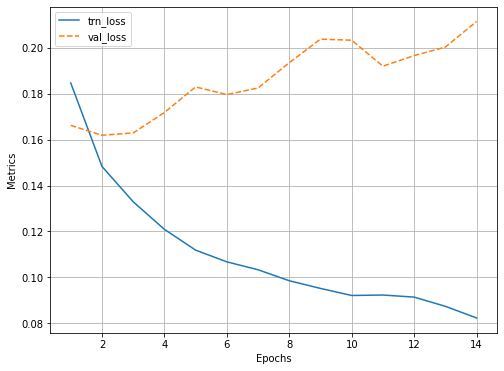

In [16]:
log.plot_epochs(['trn_loss','val_loss'])

# Save results

In [17]:
df_training_result = pd.DataFrame.from_dict(epochs_summary)
df_training_result.to_csv(join(OUTPUT_REPORTS, output_training_report), index=False)
df_training_result.head(5)

,epoch,time,loss,loss_classifier,loss_box_reg,loss_objectness,loss_rpn_box_reg
0,0,0.705694,1.382308,1.062186,0.290084,0.021461,0.008578
1,0,0.648374,0.757160,0.471357,0.259897,0.019422,0.006484
2,0,0.636158,0.442531,0.211634,0.200191,0.023782,0.006924
3,0,0.666274,0.414231,0.205684,0.179366,0.019670,0.009511
4,0,0.643864,0.453596,0.254380,0.182365,0.008665,0.008186


In [24]:
df_training_result['time'].sum() / 3600

2.977663394742542

In [22]:
df_training_result[df_training_result['epoch'] == 0]['time'].sum()

764.2091262340546

In [25]:
df_training_result['time'].shape

(17052,)

# Save Model

In [18]:
# Save
torch.save(model.state_dict(), join(OUTPUT_MODELS, output_model_name))